## Deterministic world and A* search algorithm

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
node_name = 1
pos_dict = {}
G = nx.Graph()
for i in range(1,8):
    for j in range(1,8):
        G.add_node(node_name,pos=[j,7-i])
        pos_dict.update({node_name:[j,7-i]})
        node_name +=1

In [3]:
for edge in range(1,50,7):
    if edge < 41:
        G.add_edge(edge,edge+7)
    for nxt_edge in range(0,7):
        if nxt_edge != 6:
            G.add_edge(edge+nxt_edge,edge+nxt_edge+1)
        if edge < 41:
            G.add_edge(nxt_edge+edge,nxt_edge+edge+7)

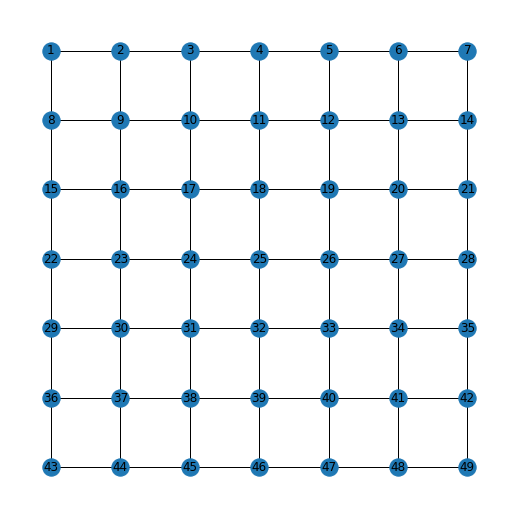

In [4]:
plt.figure(3,figsize=(7,7))   
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos,with_labels=True)

In [5]:
del_edges = [[2,3],[3,10],[3,4],[4,5],[5,12],[5,6],
            [8,15],[15,16],[15,22],[9,16],[16,23],[16,17],
            [28,35],[35,42],[34,35],
            [38,39],[39,40],[32,39],[39,46],[45,46],[46,47]]

In [6]:
for edge in del_edges:
    G.remove_edge(edge[0],edge[1])

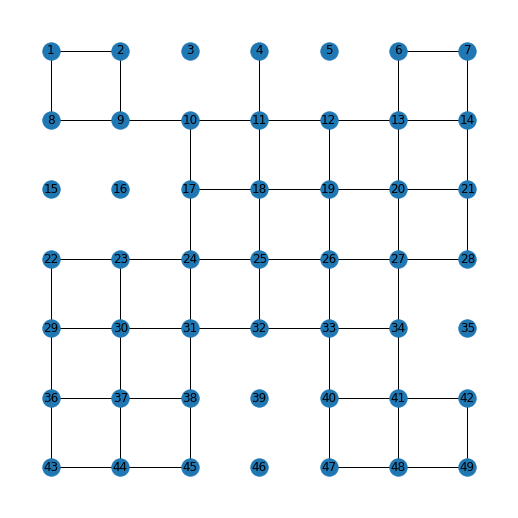

In [7]:
plt.figure(3,figsize=(7,7))     
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos,with_labels=True)

In [8]:
def manhattan_dist(a,b):
    (x1,y1),(x2,y2) = (pos_dict[a]),(pos_dict[b])
    return (abs(x2-x1) + abs(y2-y1))

In [9]:
#source = input("Enter source: ")
#destination = input("Enter Destination: ")
source = 'R'
destination = 'Y'
dist_map = {'R':1,'G':14,'Y':44,'B':47}
a_star = nx.astar_path(G, dist_map[source], dist_map[destination], heuristic=manhattan_dist,weight="weight")

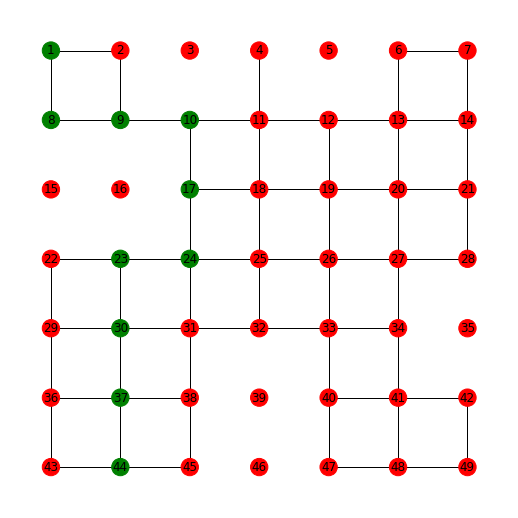

In [10]:
color_map = []
for node in G.nodes:
    if node in a_star:
        color_map.append('green')
    else: 
        color_map.append('red')      
plt.figure(3,figsize=(7,7))     
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos,node_color=color_map,with_labels=True)
plt.savefig("a_star.png")

## Non-Deterministic world and RL algorithms

In [11]:
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
from gym.envs.registration import register
import numpy as np
import random
from IPython.display import clear_output
import gym

In [12]:
MAP = [
    "+-------------+",
    "|R: | : : | : |",
    "| : : : : : :G|",
    "|---- : : : : |",
    "| : : : : : : |",
    "| : : : : : --|",
    "| : : : | : : |",
    "| :Y: : |B: : |",
    "+-------------+",
]

class TaxiEnv(discrete.DiscreteEnv):

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self):
        self.desc = np.asarray(MAP, dtype="c")

        self.locs = locs = [(0, 0), (1, 6), (6, 1), (6, 4)]

        num_states = 7*7*5*4
        num_rows = 7
        num_columns = 7
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = (
                                -1
                            )  # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0 and self.desc[2+row,col+1] != b'-':
                                new_row = min(row + 1, max_row)
                            elif action == 1 and self.desc[row,col+1] != b'-':
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if pass_idx < 4 and taxi_loc == locs[pass_idx]:
                                    new_pass_idx = 4
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx
                            )
                            P[state][action].append((1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib
        )

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 7
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 7)
        i = i // 7
        out.append(i)
        assert 0 <= i < 7
        return reversed(out)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode("utf-8") for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x):
            return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], "yellow", highlight=True
            )
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(
                out[1 + pi][2 * pj + 1], "blue", bold=True
            )
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), "green", highlight=True
            )

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], "magenta")
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write(
                f"  ({['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][self.lastaction]})\n"
            )
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

In [13]:
register(
    id='eff_taxi-v1',
    entry_point=f"{__name__}:TaxiEnv",
    reward_threshold=8,  # optimum = 8.46
    max_episode_steps=200,
)

Exploration vs Exploitation

In [14]:
def eps_greedy(Q, s, eps=0.1):
    if np.random.uniform(0,1) < eps:
        # Choose a random action
        return np.random.randint(Q.shape[1])
    else:
        # Choose the action of a greedy policy
        return greedy(Q, s)

Exploitation once the agent is trained

In [15]:
def greedy(Q, s):
    return np.argmax(Q[s])

In [16]:
def agent_evaluation(env, Q, num_episodes):
    tot_rew = []
    frames = [] 
    state = env.reset()
    total_epochs = []

    for _ in range(num_episodes):
        done = False
        game_rew = epochs = 0

        while not done:
            # select a greedy action
            next_state, rew, done, _ = env.step(greedy(Q, state))
            #print("NEXT STATE: ",next_state)
            action = greedy(Q, state)
            
            state = next_state
            game_rew += rew 
            epochs += 1
            if done:
                state = env.reset()
                tot_rew.append(game_rew)
        total_epochs.append(epochs)
    return np.mean(tot_rew),np.mean(total_epochs)


In [17]:
def Q_learning(env, lr, num_episodes, eps, gamma, eps_decay):
    nA = env.action_space.n #number of actions
    nS = env.observation_space.n #number of states
    # Q: matrix nS*nA where each row represent a state and each colums represent a different action
    Q = np.zeros((nS, nA))
    games_reward = []
    test_rewards = []
    test_epochs = []
    episode_list = []

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        tot_rew = 0
        
        # loop the main body until the environment stops
        while not done:
            # select an action following the eps-greedy policy
            action = eps_greedy(Q, state, eps)

            next_state, rew, done, _ = env.step(action) # Take one step in the environment

            # Q-learning update the state-action value (get the max Q value for the next state)
            Q[state][action] = Q[state][action] + lr*(rew + gamma*np.max(Q[next_state]) - Q[state][action])

            state = next_state
            tot_rew += rew
            if done:
                games_reward.append(tot_rew)
                     
    return Q

In [18]:
def SARSA(env, lr, num_episodes, eps, gamma, eps_decay):
    nA = env.action_space.n
    nS = env.observation_space.n

    # Initialize the Q matrix
    # Q: matrix nS*nA where each row represent a state and each colums represent a different action
    Q = np.zeros((nS, nA))
    games_reward = []
    test_rewards = []
    test_epochs = []
    episode_list = []


    for ep in range(num_episodes):
        state = env.reset()
        done = False
        tot_rew = 0

        action = eps_greedy(Q, state, eps) 

        # loop the main body until the environment stops
        while not done:
            next_state, rew, done, _ = env.step(action) # Take one step in the environment

            # choose the next action (needed for the SARSA update)
            next_action = eps_greedy(Q, next_state, eps) 
            # SARSA update
            Q[state][action] = Q[state][action] + lr*(rew + gamma*Q[next_state][next_action] - Q[state][action])

            state = next_state
            action = next_action
            tot_rew += rew
            if done:
                games_reward.append(tot_rew)

    return Q

Train and evaluate agent on Q learning and SARSA for different parameters

In [19]:
lr = [0.1,0.5,0.9]
train_episodes = 10000
gamma=[0.6,0.9]
eps = [0.5,0.6]
eps_decay = 0.001
eval_episode = [100,250,500,750,1000,1250,1500,1750,2000,2250,2500]
q_learning_rewards = []
q_learning_epochs = []
q_learning_episodes = []
sarsa_learning_rewards = []
sarsa_learning_epochs = []
sarsa_learning_episodes = []
for alpha in lr:
    for g in gamma:
        for e in eps:
            env = gym.make("eff_taxi-v1")
            Q_qlearning = Q_learning(env,alpha,train_episodes,e,g,eps_decay)
            q_rewards = []
            q_epochs = []
            sarsa_rewards = []
            sarsa_epochs = []
            for episode in eval_episode:
                rewards,epochs = agent_evaluation(env,Q_qlearning,episode)
                q_rewards.append(rewards)
                q_epochs.append(epochs)
            q_learning_rewards.append(q_rewards)
            q_learning_epochs.append(q_epochs)
            q_learning_episodes.append(eval_episode)
            env = gym.make("eff_taxi-v1")
            Q_sarsa = SARSA(env,alpha,train_episodes,e,g,eps_decay)
            for episode in eval_episode:
                rewards,epochs = agent_evaluation(env,Q_sarsa,episode)
                sarsa_rewards.append(rewards)
                sarsa_epochs.append(epochs)
            sarsa_learning_episodes.append(eval_episode)
            sarsa_learning_epochs.append(sarsa_epochs)
            sarsa_learning_rewards.append(sarsa_rewards)

## Plot graphs for comparision

In [20]:
import matplotlib.pyplot as plt

### Avg reward vs episode comparision

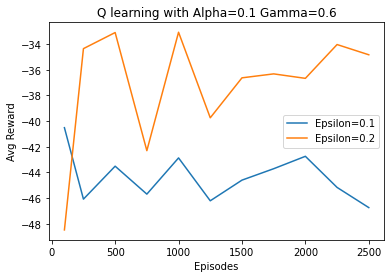

In [21]:
plt.plot(q_learning_episodes[0],q_learning_rewards[0], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[1],q_learning_rewards[1],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('Q learning with Alpha=0.1 Gamma=0.6')
plt.legend()
plt.show()

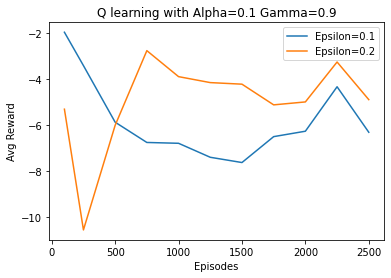

In [22]:
plt.plot(q_learning_episodes[2],q_learning_rewards[2], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[3],q_learning_rewards[3],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('Q learning with Alpha=0.1 Gamma=0.9')
plt.legend()
plt.show()

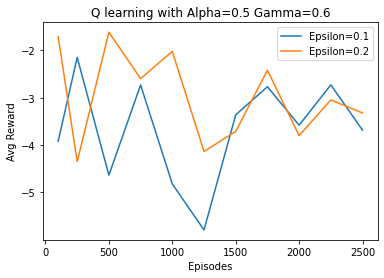

In [23]:
plt.plot(q_learning_episodes[4],q_learning_rewards[4], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[5],q_learning_rewards[5],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('Q learning with Alpha=0.5 Gamma=0.6')
plt.legend()
plt.show()

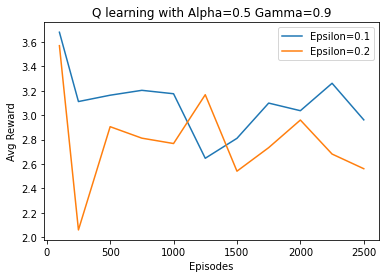

In [24]:
plt.plot(q_learning_episodes[6],q_learning_rewards[6], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[7],q_learning_rewards[7],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('Q learning with Alpha=0.5 Gamma=0.9')
plt.legend()
plt.show()

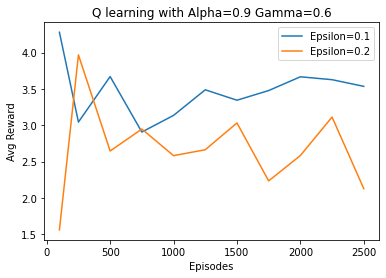

In [25]:
plt.plot(q_learning_episodes[8],q_learning_rewards[8], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[9],q_learning_rewards[9],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('Q learning with Alpha=0.9 Gamma=0.6')
plt.legend()
plt.show()

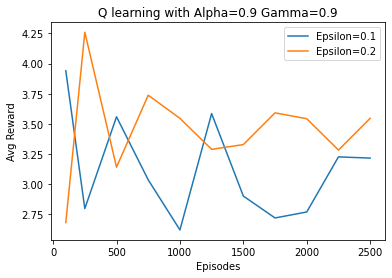

In [26]:
plt.plot(q_learning_episodes[10],q_learning_rewards[10], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[11],q_learning_rewards[11],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('Q learning with Alpha=0.9 Gamma=0.9')
plt.legend()
plt.show()

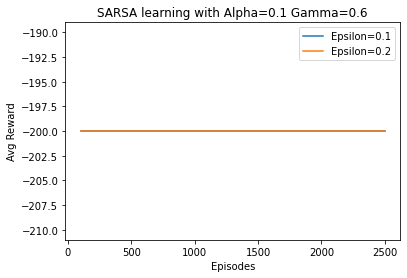

In [27]:
plt.plot(sarsa_learning_episodes[0],sarsa_learning_rewards[0], label = "Epsilon=0.1")
plt.plot(sarsa_learning_episodes[1],sarsa_learning_rewards[1],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('SARSA learning with Alpha=0.1 Gamma=0.6')
plt.legend()
plt.show()

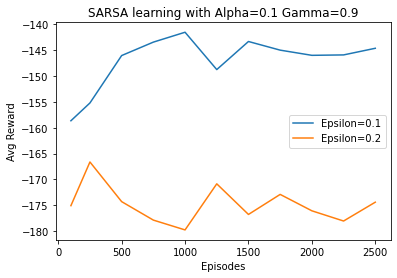

In [28]:
plt.plot(sarsa_learning_episodes[2],sarsa_learning_rewards[2], label = "Epsilon=0.1")
plt.plot(sarsa_learning_episodes[3],sarsa_learning_rewards[3],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('SARSA learning with Alpha=0.1 Gamma=0.9')
plt.legend()
plt.show()

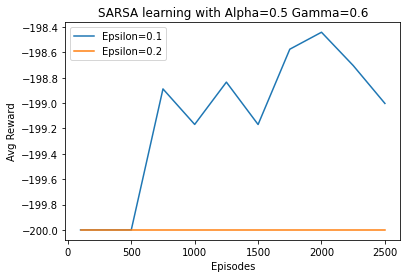

In [29]:
plt.plot(sarsa_learning_episodes[4],sarsa_learning_rewards[4], label = "Epsilon=0.1")
plt.plot(sarsa_learning_episodes[5],sarsa_learning_rewards[5],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('SARSA learning with Alpha=0.5 Gamma=0.6')
plt.legend()
plt.show()

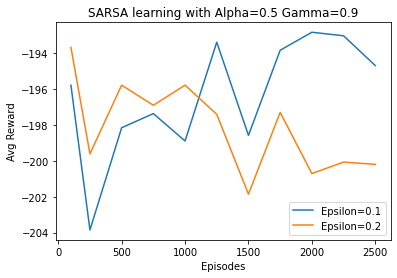

In [30]:
plt.plot(sarsa_learning_episodes[6],sarsa_learning_rewards[6], label = "Epsilon=0.1")
plt.plot(sarsa_learning_episodes[7],sarsa_learning_rewards[7],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('SARSA learning with Alpha=0.5 Gamma=0.9')
plt.legend()
plt.show()

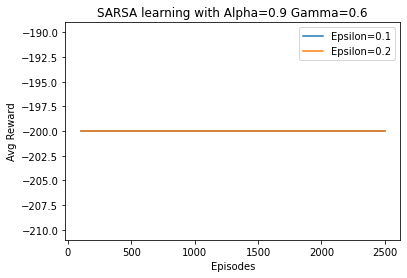

In [31]:
plt.plot(sarsa_learning_episodes[8],sarsa_learning_rewards[8], label = "Epsilon=0.1")
plt.plot(sarsa_learning_episodes[9],sarsa_learning_rewards[9],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('SARSA learning with Alpha=0.9 Gamma=0.6')
plt.legend()
plt.show()

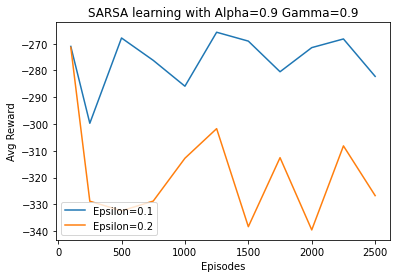

In [32]:
plt.plot(sarsa_learning_episodes[10],sarsa_learning_rewards[10], label = "Epsilon=0.1")
plt.plot(sarsa_learning_episodes[11],sarsa_learning_rewards[11],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.title('SARSA learning with Alpha=0.9 Gamma=0.9')
plt.legend()
plt.show()

## Avg epochs vs episode comparision

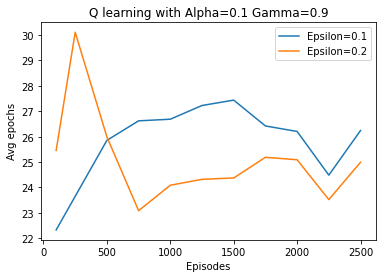

In [33]:
plt.plot(q_learning_episodes[2],q_learning_epochs[2], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[3],q_learning_epochs[3],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg epochs')
plt.title('Q learning with Alpha=0.1 Gamma=0.9')
plt.legend()
plt.show()

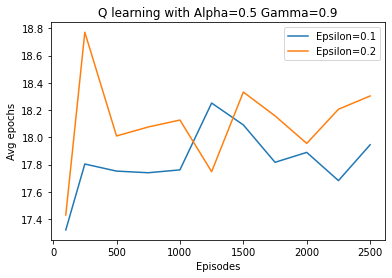

In [34]:
plt.plot(q_learning_episodes[6],q_learning_epochs[6], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[7],q_learning_epochs[7],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg epochs')
plt.title('Q learning with Alpha=0.5 Gamma=0.9')
plt.legend()
plt.show()

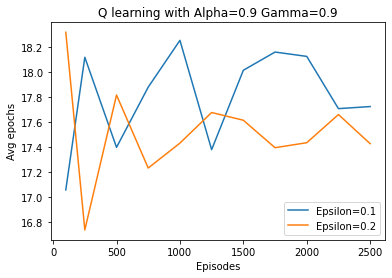

In [35]:
plt.plot(q_learning_episodes[10],q_learning_epochs[10], label = "Epsilon=0.1")
plt.plot(q_learning_episodes[11],q_learning_epochs[11],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg epochs')
plt.title('Q learning with Alpha=0.9 Gamma=0.9')
plt.legend()
plt.show()

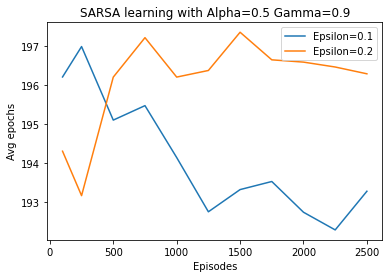

In [36]:
plt.plot(sarsa_learning_episodes[6],sarsa_learning_epochs[6], label = "Epsilon=0.1")
plt.plot(sarsa_learning_episodes[7],sarsa_learning_epochs[7],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg epochs')
plt.title('SARSA learning with Alpha=0.5 Gamma=0.9')
plt.legend()
plt.show()

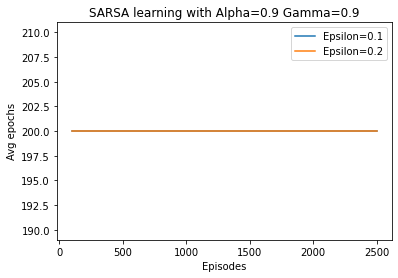

In [37]:
plt.plot(sarsa_learning_episodes[10],sarsa_learning_epochs[10], label = "Epsilon=0.1")
plt.plot(sarsa_learning_episodes[11],sarsa_learning_epochs[11],label = "Epsilon=0.2")
plt.xlabel('Episodes')
plt.ylabel('Avg epochs')
plt.title('SARSA learning with Alpha=0.9 Gamma=0.9')
plt.legend()
plt.show()

Agent Visualisation

In [38]:
env = gym.make("eff_taxi-v1")
Q_qlearning = Q_learning(env,0.5,10000,0.1,0.9,0.001)

In [39]:
def agent_visualisation(env, Q, num_episodes):
    tot_rew = []
    frames = [] 
    state = env.reset()
    total_epochs = []

    for _ in range(num_episodes):
        done = False
        game_rew = epochs = 0

        while not done:
            # select a greedy action
            next_state, rew, done, _ = env.step(greedy(Q, state))
            #print("NEXT STATE: ",next_state)
            action = greedy(Q, state)
            
            state = next_state
            game_rew += rew 
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': next_state,
                'action': action,
                'creward': game_rew
            })
            epochs += 1
            if done:
                state = env.reset()
                tot_rew.append(game_rew)
        total_epochs.append(epochs)
    return frames


In [40]:
frames = agent_visualisation(env,Q_qlearning,100)

In [ ]:
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['creward']}")
        sleep(1)
        
print_frames(frames)

+-------------+
|R: | : : | : |
| : :_: : : :G|
|---- : : : : |
| : : : : : : |
| : : : : : --|
| : : : | : : |
| :Y: : |B: : |
+-------------+
  (West)

Timestep: 1054
State: 196
Action: 3
Reward: -10
